In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


# Loading Data

In [6]:
data = pd.read_csv('./data_processed/data_first_record_with_commorbidities.csv', index_col=0)
data.fillna(data.mean(), inplace=True)
data.los = (data.los > 4).astype(int)

In [7]:
def run(data):
    X = data.loc[:, data.columns != 'los']
    y = data.loc[:, data.columns == 'los']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LogisticRegression(max_iter=1000)

    model.fit(X_train, y_train)
    
    res = pd.DataFrame(model.coef_.reshape(-1), index=X.columns, columns=['Coefficient'])
    
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy with best parameters: {accuracy * 100.0}")
    
    y_scores = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 5), dpi=300)

    plt.plot(fpr, 
            tpr, 
            color='darkorange', 
            lw=2, 
            label=f'ROC curve (area = {roc_auc:.2f})')

    plt.fill_between(fpr, tpr, color='darkorange', alpha=0.2)  # alpha 参数控制填充颜色的透明度


    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    return res, model

Accuracy with best parameters: 77.86259541984732


c:\Users\sitdo\.conda\envs\ibd\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


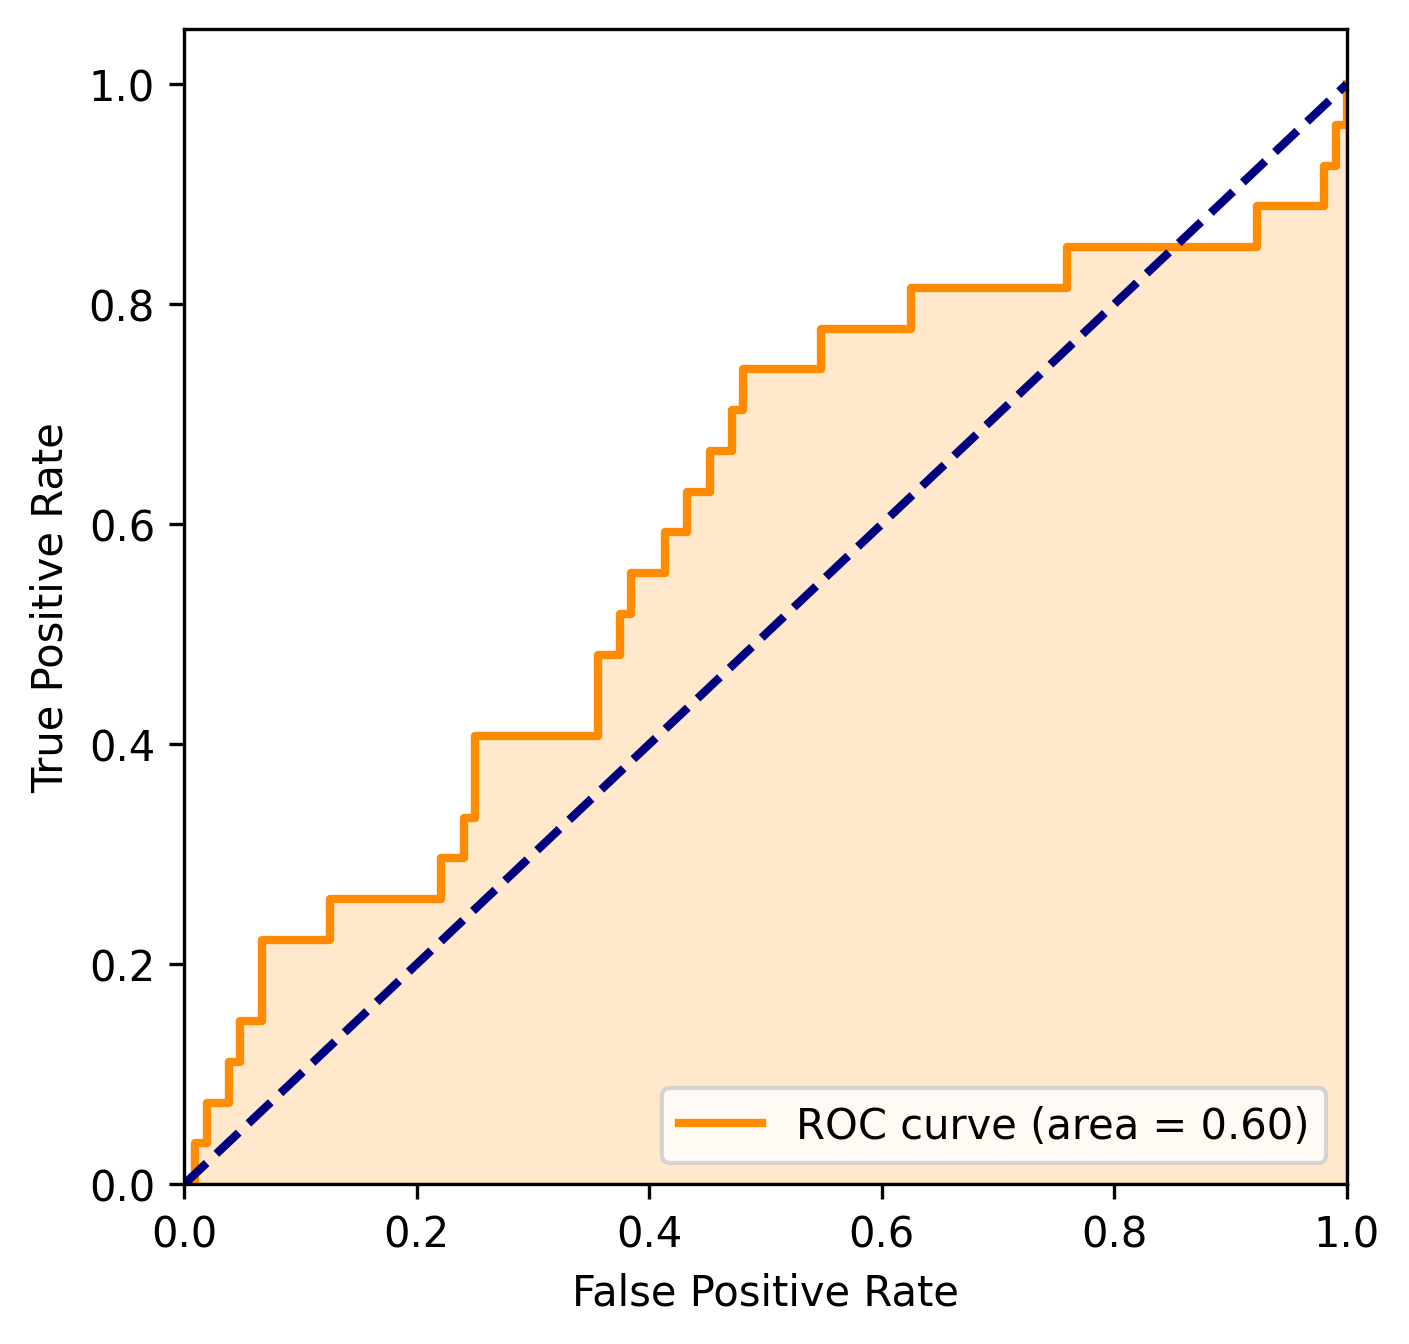

,Coefficient
gender,-0.235720
age,-0.089606
heart_rate,0.187192
respiratory_rate,0.224247
hematocrit,0.067166
rdw,0.013008
platelet,0.166279
mcv,-0.051132
mch,0.103086
hemoglobin,-0.102333


In [8]:
res, model = run(data)

res